# 3D Convolutional Neural Network for Tomographic Alignment

## Regular CNN Expanding the Dataset

In order to test potential methods for performing automatic tomographic alignment using neural networks, we start with a standard model using a three dimensional convolution. The main problem with tomographic alignment is that a stack of two dimensional projections have to be processed simultameously for optimal results. While two dimensional convolutions can be used with channels corresponding with each projection angle, this is likely similar in computational complexity to a three dimensional neural network. Therefore the approach for this test is similar to video classification, where each frame in a video is is instead each projection angle. Now the dataset will be expanded to be larger in order to determine if this can be generalized on the phantom data.

In order to test if this method can provide a convergence, phantoms will be artificially misaligned to create a training and testing set. But first packages for tomography, image transformations, and neural networks have to be imported.

In [1]:
# Import essential packages
import os
import numpy as np
import matplotlib.pyplot as plt

# Import tomography and imaging packages
import tomopy
from skimage.transform import rotate, AffineTransform
from skimage import transform as tf

# Import neural net packages
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.profiler
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader
from torchinfo import summary

Since the model will be a computationally complex CNN, we must ensure that the GPU is being used for calculations or else computation will be far too slow.

In [2]:
# Checking to ensure environment and cuda are correct
print("Working Environment: {}".format(os.environ['CONDA_DEFAULT_ENV']))
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
print("Cuda Version: {}".format(torch.version.cuda))
print("Cuda Availability: {}".format(torch.cuda.is_available()))

Working Environment: pytorch
Cuda Version: 11.8
Cuda Availability: True


Now that the packages have been imported and CUDA is set up correctly, the next step is to create the dataset to be used for training and testing the neural network. The misalignment function is created to perform different random misalignments on the phantom set of tomographic scans. The shape of all of the data is then checked for errors and the data is split into training and testing sets.

In [3]:
# Define function for artificial misalignment
def misalign(prj, mis_axis, ang_tilt = False, noise = False, background = False):
    num_prj, col, row = prj.shape
    dx = mis_axis[:, 0]
    dy = mis_axis[:, 1]
    prj_tmp = tomopy.shift_images(prj, dx, dy)
    
    for i in range(num_prj):
        d_row, d_col, d_ang = mis_axis[i]
        
        if ang_tilt == True:
            prj_tmp[i, :, :] = rotate(prj[i,:,:], d_ang)
        else:
            prj_tmp[i, :, :] = prj[i,:,:]
        
        if noise == True:
            prj_tmp[i, :, :] = random_noise(prj_tmp[i, :, :], mode = 'gaussian')
            
        if background == True:
            prj_tmp[i, :, :] = prj_tmp[i, :, :]+np.random.random()/5
            prj_tmp[i, :, :] = prj_tmp[i, :, :]/prj_tmp[i, :, :].max()  
            
    return prj_tmp

In [4]:
# Creating ground truth tomography
data = tomopy.shepp3d(128)
ang = tomopy.angles(180)
proj = tomopy.project(data, ang)

In [5]:
# Create dataset to store misaligned projections and 
training_entries = 100
entries = int(np.ceil(training_entries * 5 / 4))
dataset = np.zeros((entries, 2), dtype = object)

for i in range(entries):
    # Randomly determined misalignment axis
    mis_axis = np.random.normal(0, 1, (200, 3))
    mis_axis[:, :1] = mis_axis[:, :1]*4
    mis_axis = np.round(mis_axis).astype(int)
    mis_axis_in = np.expand_dims(mis_axis, axis = 0)
    
    proj_mis = misalign(proj.copy(), mis_axis, ang_tilt = True)
    proj_mis = np.expand_dims(proj_mis, axis = 0)
    proj_mis = np.expand_dims(proj_mis, axis = 0)
    
    dataset[i, 0] = proj_mis
    dataset[i, 1] = np.concatenate((mis_axis_in[:, :180, 0], mis_axis_in[:, :180, 1]), axis = 1)

In [6]:
# Checking shape of dataset
print(dataset.shape)
print(dataset[0].shape)
print(dataset[0][0].shape)
print(dataset[0][1].shape)

(125, 2)
(2,)
(1, 1, 180, 128, 184)
(1, 360)


In [7]:
# Checking shape of training and testing splits
trainset, testset = np.split(dataset, [training_entries])
print(trainset.shape)
print(testset.shape)

(100, 2)
(25, 2)


Now that the data has been set up, the CUDA cache should be cleared and the model will be implemented.

In [8]:
torch.cuda.empty_cache()
print("Cleared Cache.")

Cleared Cache.


In [9]:
# Normalize data
def norm(proj):
    proj = (proj - torch.min(proj)) / (torch.max(proj) - torch.min(proj))
    return proj

# 3D CNN to determine shift parameters

class CNN_3D_aligner(nn.Module):
    def __init__(self):
        super(CNN_3D_aligner, self).__init__()

        self.group1 = nn.Sequential(
            nn.Conv3d(1, 16, kernel_size=(3, 3, 3), padding=1), 
            nn.BatchNorm3d(16),
            nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2)) 
        )
        
        self.group2 = nn.Sequential(
            nn.Conv3d(16, 32, kernel_size=(3, 3, 3), padding=1), 
            nn.BatchNorm3d(32),
            nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2)) 
        )
        
        self.group3 = nn.Sequential(
            nn.Conv3d(32, 64, kernel_size=(3, 3, 3), padding=1), 
            nn.BatchNorm3d(64),
            nn.Conv3d(64, 64, kernel_size=(3, 3, 3), padding=1), 
            nn.BatchNorm3d(64),
            nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2)) 
        )
        
        self.group4 = nn.Sequential(
            nn.Conv3d(64, 128, kernel_size=(3, 3, 3), padding=1), 
            nn.BatchNorm3d(128),
            nn.Conv3d(128, 128, kernel_size=(3, 3, 3), padding=1), 
            nn.BatchNorm3d(128),
            nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2)) 
        )
        
        self.group5 = nn.Sequential(
            nn.Conv3d(128, 256, kernel_size=(3, 3, 3), padding=1), 
            nn.BatchNorm3d(256),
            nn.Conv3d(256, 256, kernel_size=(3, 3, 3), padding=1), 
            nn.BatchNorm3d(256),
            nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2)) 
        )
        
        self.group6 = nn.Sequential(
            nn.Conv3d(256, 16, kernel_size=(3, 3, 3), padding=1),
            nn.BatchNorm3d(16),
        )
        
        self.flatten = nn.Flatten()
        
        self.fc1 = nn.Sequential(
            nn.Linear(1600, 512),
            nn.Dropout(0.25),
            nn.Linear(512, 256)
        )
        
        self.fc2 = nn.Linear(256, 360)

    def forward(self, x):
        
        x = norm(x)
        
        x = self.group1(x)
        x = self.group2(x)
        x = self.group3(x)
        x = self.group4(x)
        x = self.group5(x)
        x = self.group6(x)
        
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.fc2(x)
        
        return x

In order to ensure the network works and understand its structure before training data on it, use the summary function in order to get an understanding of the network and fix any linear algebra errors in creating the neural network.

In [10]:
# Test model shape
model = CNN_3D_aligner()
summary(model, (1, 1, 180, 128, 184))

Layer (type:depth-idx)                   Output Shape              Param #
CNN_3D_aligner                           [1, 360]                  --
├─Sequential: 1-1                        [1, 16, 90, 64, 92]       --
│    └─Conv3d: 2-1                       [1, 16, 180, 128, 184]    448
│    └─BatchNorm3d: 2-2                  [1, 16, 180, 128, 184]    32
│    └─MaxPool3d: 2-3                    [1, 16, 90, 64, 92]       --
├─Sequential: 1-2                        [1, 32, 45, 32, 46]       --
│    └─Conv3d: 2-4                       [1, 32, 90, 64, 92]       13,856
│    └─BatchNorm3d: 2-5                  [1, 32, 90, 64, 92]       64
│    └─MaxPool3d: 2-6                    [1, 32, 45, 32, 46]       --
├─Sequential: 1-3                        [1, 64, 22, 16, 23]       --
│    └─Conv3d: 2-7                       [1, 64, 45, 32, 46]       55,360
│    └─BatchNorm3d: 2-8                  [1, 64, 45, 32, 46]       128
│    └─Conv3d: 2-9                       [1, 64, 45, 32, 46]       110,656


Now the model can be trained, making sure to move all of the elements of the training process to the GPU to optimize computational speed.

In [18]:
# Train the model

# Create writer and profiler to analyze loss over each epoch
writer = SummaryWriter()

# Set device to CUDA if available, initialize model
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Device: {}'.format(device))
net = CNN_3D_aligner()
net.to(device)

# Set up optimizer and loss function, set number of epochs
optimizer = optim.SGD(net.parameters(), lr = 1e-4, momentum=0.9)
criterion = nn.MSELoss(reduction = 'mean')
criterion.to(device)
num_epochs = 250

# Iniitializing variables to show statistics
iteration = 0
test_iteration = 0
loss_list = []
test_loss_list = []
epoch_loss_averages = []
test_epoch_loss_averages = []

# Iterates over dataset multiple times
for epoch in range(num_epochs):
    
    epoch_loss = 0
    test_epoch_loss = 0
    
    for i, data in enumerate(trainset, 0):
        
        inputs, truths = norm(torch.from_numpy(data[0]).to(device)), torch.from_numpy(data[1]).to(device).float()
        optimizer.zero_grad()

        outputs = net(inputs).to(device)
        loss = criterion(outputs, truths)
        writer.add_scalar("Loss / Train", loss, epoch) # adds training loss scalar
        loss_list.append(loss.cpu().detach().numpy())
        epoch_loss += loss.cpu().detach().numpy()
        loss.backward()
        optimizer.step()

        iteration += 1
        if iteration % trainset.shape[0] == 0:
            epoch_loss_averages.append(epoch_loss / trainset.shape[0])
            print('Epoch: {}   Training Loss: {} '.format(epoch, epoch_loss / trainset.shape[0]))
            
    for i, test_data in enumerate(testset, 0):
        
        inputs, truths = norm(torch.from_numpy(test_data[0]).to(device)), torch.from_numpy(test_data[1]).to(device).float()
        outputs = net(inputs).to(device)
        test_loss = criterion(outputs, truths)
        
        writer.add_scalar("Loss / Test", test_loss, epoch) # adds testing loss scalar
        test_loss_list.append(test_loss.cpu().detach().numpy())
        test_epoch_loss += test_loss.cpu().detach().numpy()
        
        test_iteration +=1
        if test_iteration % testset.shape[0] == 0:
            test_epoch_loss_averages.append(test_epoch_loss / testset.shape[0])
            print('Epoch: {}   Testing Loss: {} '.format(epoch, test_epoch_loss / testset.shape[0]))
            
writer.flush()
writer.close()

Device: cuda:0
Epoch: 0   Training Loss: 8.793318123817444 
Epoch: 0   Testing Loss: 8.325324363708496 
Epoch: 1   Training Loss: 8.734093523025512 
Epoch: 1   Testing Loss: 8.32858507156372 
Epoch: 2   Training Loss: 8.69584065437317 
Epoch: 2   Testing Loss: 8.359187068939208 
Epoch: 3   Training Loss: 8.666551084518433 
Epoch: 3   Testing Loss: 8.350412044525147 
Epoch: 4   Training Loss: 8.619072303771972 
Epoch: 4   Testing Loss: 8.363710250854492 
Epoch: 5   Training Loss: 8.52696367263794 
Epoch: 5   Testing Loss: 8.3968967628479 
Epoch: 6   Training Loss: 8.356963062286377 
Epoch: 6   Testing Loss: 8.38445592880249 
Epoch: 7   Training Loss: 8.12868685245514 
Epoch: 7   Testing Loss: 8.354944267272948 
Epoch: 8   Training Loss: 7.92053183555603 
Epoch: 8   Testing Loss: 8.345095691680909 
Epoch: 9   Training Loss: 7.775568113327027 
Epoch: 9   Testing Loss: 8.323350601196289 
Epoch: 10   Training Loss: 7.679182415008545 
Epoch: 10   Testing Loss: 8.332823944091796 
Epoch: 11   

Epoch: 90   Testing Loss: 8.973290195465088 
Epoch: 91   Training Loss: 1.9232703936100006 
Epoch: 91   Testing Loss: 8.81376953125 
Epoch: 92   Training Loss: 1.929992107152939 
Epoch: 92   Testing Loss: 8.850815143585205 
Epoch: 93   Training Loss: 1.922905184030533 
Epoch: 93   Testing Loss: 8.795391654968261 
Epoch: 94   Training Loss: 1.8548858487606048 
Epoch: 94   Testing Loss: 8.730340766906739 
Epoch: 95   Training Loss: 1.820324079990387 
Epoch: 95   Testing Loss: 8.997866382598877 
Epoch: 96   Training Loss: 1.8157422149181366 
Epoch: 96   Testing Loss: 8.956126861572265 
Epoch: 97   Training Loss: 1.790838179588318 
Epoch: 97   Testing Loss: 8.873952808380126 
Epoch: 98   Training Loss: 1.776229695081711 
Epoch: 98   Testing Loss: 8.896875228881836 
Epoch: 99   Training Loss: 1.7655360436439513 
Epoch: 99   Testing Loss: 8.910537509918212 
Epoch: 100   Training Loss: 1.770086555480957 
Epoch: 100   Testing Loss: 8.82753782272339 
Epoch: 101   Training Loss: 1.72361298322677

Epoch: 178   Testing Loss: 8.931179294586181 
Epoch: 179   Training Loss: 1.0089993107318878 
Epoch: 179   Testing Loss: 8.954056377410888 
Epoch: 180   Training Loss: 0.9581072223186493 
Epoch: 180   Testing Loss: 8.878962173461915 
Epoch: 181   Training Loss: 0.9873437374830246 
Epoch: 181   Testing Loss: 9.050045375823975 
Epoch: 182   Training Loss: 0.9681277620792389 
Epoch: 182   Testing Loss: 9.04552583694458 
Epoch: 183   Training Loss: 0.9791577214002609 
Epoch: 183   Testing Loss: 8.926215343475342 
Epoch: 184   Training Loss: 0.9481297945976257 
Epoch: 184   Testing Loss: 8.907053203582764 
Epoch: 185   Training Loss: 0.96627936065197 
Epoch: 185   Testing Loss: 8.978461589813232 
Epoch: 186   Training Loss: 0.952237007021904 
Epoch: 186   Testing Loss: 8.997892837524414 
Epoch: 187   Training Loss: 0.9330206120014191 
Epoch: 187   Testing Loss: 8.856536712646484 
Epoch: 188   Training Loss: 0.9409269905090332 
Epoch: 188   Testing Loss: 9.013673210144043 
Epoch: 189   Train

Now in order to observe convergence or lack thereof a graph of loss per epoch are created for analysis.

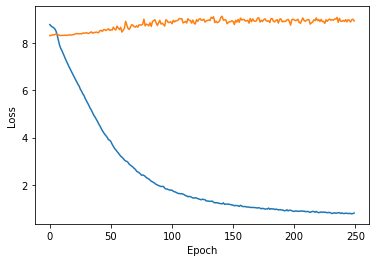

In [21]:
# Plot epoch loss to test for convergence
plt.plot(epoch_loss_averages)
plt.plot(test_epoch_loss_averages)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

As seen above, the neural network is able to create convergence for the training data to the subpixel level. However, the testing loss does not converge indicating that this model has a overfitting problem.